In [842]:
%matplotlib notebook

In [843]:
import numpy as np
import math
from spatialmath import SE3
from spatialmath.base import e2h, h2e
from roboticstoolbox import *
from machinevisiontoolbox import CentralCamera

In [844]:
cam = CentralCamera(f=[919.21981864*10e-6,913.16565134*10e-6], rho=10e-6, imagesize=[640, 480], pp=[356.41270451,236.9305], name="mycamera")
print(cam)

           Name: mycamera [CentralCamera]
     pixel size: 1e-05 x 1e-05
     image size: 640 x 480
           pose: t = 0, 0, 0; rpy/yxz = 0°, 0°, 0°
   principal pt: [356.41270451 236.9305    ]
   focal length: [0.0091922  0.00913166]



In [845]:
P=np.array([-0.18, 0, -0.01])

In [846]:
DFbot1 = DHRobot(
    [                 
                    RevoluteMDH(d=0.04145,qlim=np.array([-np.pi,np.pi])),            
                    RevoluteMDH(alpha=np.pi/2,qlim=np.array([-np.pi,np.pi])),
                    RevoluteMDH(a=-0.08285,qlim=np.array([-np.pi,np.pi])),
                    RevoluteMDH(a=-0.08285,qlim=np.array([-np.pi,np.pi])),
                    RevoluteMDH(alpha=-np.pi/2,qlim=np.array([0,np.pi])),
                    RevoluteMDH(a=0.04,d=0.057,qlim=np.array([-np.pi,np.pi]))
                  
    ],
    name="DFbot",
)

In [908]:
DFbot2 = DHRobot(
    [                 
                    RevoluteMDH(d=0.04145,qlim=np.array([-np.pi/2,np.pi/2])),            
                    RevoluteMDH(alpha=np.pi/2,qlim=np.array([-np.pi/2,np.pi/2])),
                    RevoluteMDH(a=-0.08285,qlim=np.array([-np.pi/2,np.pi/2])),
                    RevoluteMDH(a=-0.08285,qlim=np.array([-np.pi/2,np.pi])),
                    RevoluteMDH(alpha=-np.pi/2,d=0.11,qlim=np.array([0,np.pi]))
                  
    ],
    name="DFbot",
)

In [805]:
#视觉校正

In [891]:
T1=DFbot1.fkine([0,-np.pi/3,np.pi/3,np.pi,0,0])

In [892]:
SE3(T1)

  -1         0         0        -0.1643    
   0         1         0         0         
   0         0        -1         0.0562    
   0         0         0         1         


<IPython.core.display.Javascript object>


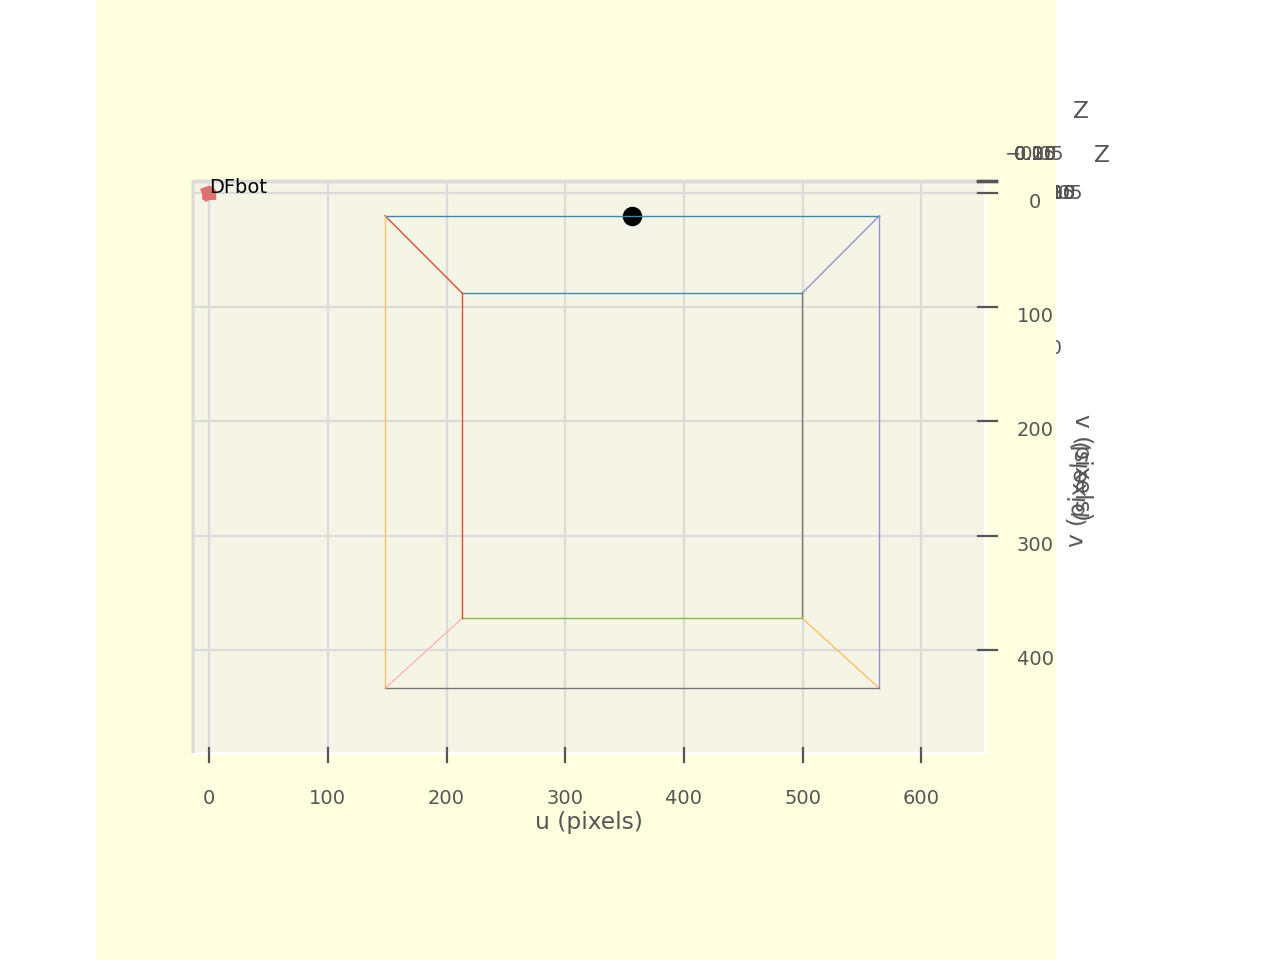

PyPlot3D backend, t = 0.05, scene:
  robot: Text(0.0, 0.0, 'DFbot')

In [850]:
DFbot1.plot([0,-np.pi/3,np.pi/3,np.pi,0,0])

In [771]:
#末端摄像机旋转90度

In [856]:
T1=DFbot1.fkine([0,-np.pi/3,np.pi/3,np.pi,0,np.pi/2])

In [857]:
SE3(T1)

   0         1         0        -0.1643    
   1         0         0         0         
   0         0        -1         0.0562    
   0         0         0         1         


In [858]:
DFbot1.plot([0,-np.pi/3,np.pi/3,np.pi,0,np.pi/2])

PyPlot3D backend, t = 0.05, scene:
  robot: Text(0.0, 0.0, 'DFbot')

In [ ]:
#单一点投影

In [859]:
p = cam.project_point(P, pose=T1 )

In [860]:
cam.plot_point(P, pose=T1 )

array([[356.41270451],
       [ 20.01984343]])

In [778]:
#立方体投影

In [861]:
from spatialmath import SE3
from machinevisiontoolbox import mkcube
X, Y, Z = mkcube(s=0.03,centre=(-0.165, 0, -0.025), edge=True)
cam.plot_wireframe(X, Y, Z,pose=T1)

In [770]:
#求解深度

In [878]:
mtx=np.array([[919.21981864,   0.        , 356.41270451],
       [  0.        , 913.16565134, 236.9305    ],
       [  0.        ,   0.        ,   1.        ]])

In [879]:
# 内参矩阵
K = mtx
 
# 位姿矩阵
pose=T1
 
# 外参矩阵（位姿矩阵的逆）
extrinsic = np.linalg.inv(pose)
 
# 3D点（世界坐标系）
point_3d = np.array([-0.165, 0, -0.01, 1])
 
# 将点从世界坐标系转换到相机坐标系
point_camera = extrinsic @ point_3d
 
# 投影到图像平面
point_2d = K @ point_camera[:3]
depth=point_2d[2]
point_2d /= depth  # 归一化

In [880]:
point_2d

array([356.41270451, 226.9298497 ,   1.        ])

In [881]:
depth

0.06620020470354074

In [882]:
xaxis=356.41270451-100
yaxis=226.9298497+50
point_2d=depth*np.array([xaxis,yaxis,1])
point_camera=e2h(np.linalg.inv(K)@point_2d)
new_point_3d=np.array(np.linalg.inv(extrinsic)@point_camera)

In [884]:
new_point_3d

array([[-0.16137524],
       [-0.00720178],
       [-0.01      ],
       [ 1.        ]])

In [915]:
T1

  -1         0         0        -0.1643    
   0         1         0         0         
   0         0        -1         0.0562    
   0         0         0         1         


In [916]:
T21=DFbot2.fkine([0,-np.pi/3,np.pi/3,np.pi,0])
T21

  -1         0         0        -0.1243    
   0         1         0         0         
   0         0        -1         0.0032    
   0         0         0         1         


In [917]:
T2=np.array(T21)
T2[:,-1]=new_point_3d.flatten()
#T2[2,-1]=0.01
T2

array([[-1.00000000e+00, -6.58801879e-33, -1.07590512e-16,
        -1.61375236e-01],
       [ 7.26201071e-33,  1.00000000e+00, -1.22464680e-16,
        -7.20178170e-03],
       [ 1.37338848e-16, -1.22464680e-16, -1.00000000e+00,
        -1.00000000e-02],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00]])

In [939]:
sol = DFbot2.ikine_LM(T2,q0=[0,-np.pi/3,np.pi/3,np.pi,0],ilimit=5000, slimit=5000,joint_limits=True,tol=0.001)
sol

IKSolution(q=array([ 0.05250454, -0.67323703,  0.68610388,  3.12762084,  0.0524625 ]), success=True, iterations=1, searches=1, residual=0.0008012692771646826, reason='Success')

<IPython.core.display.Javascript object>


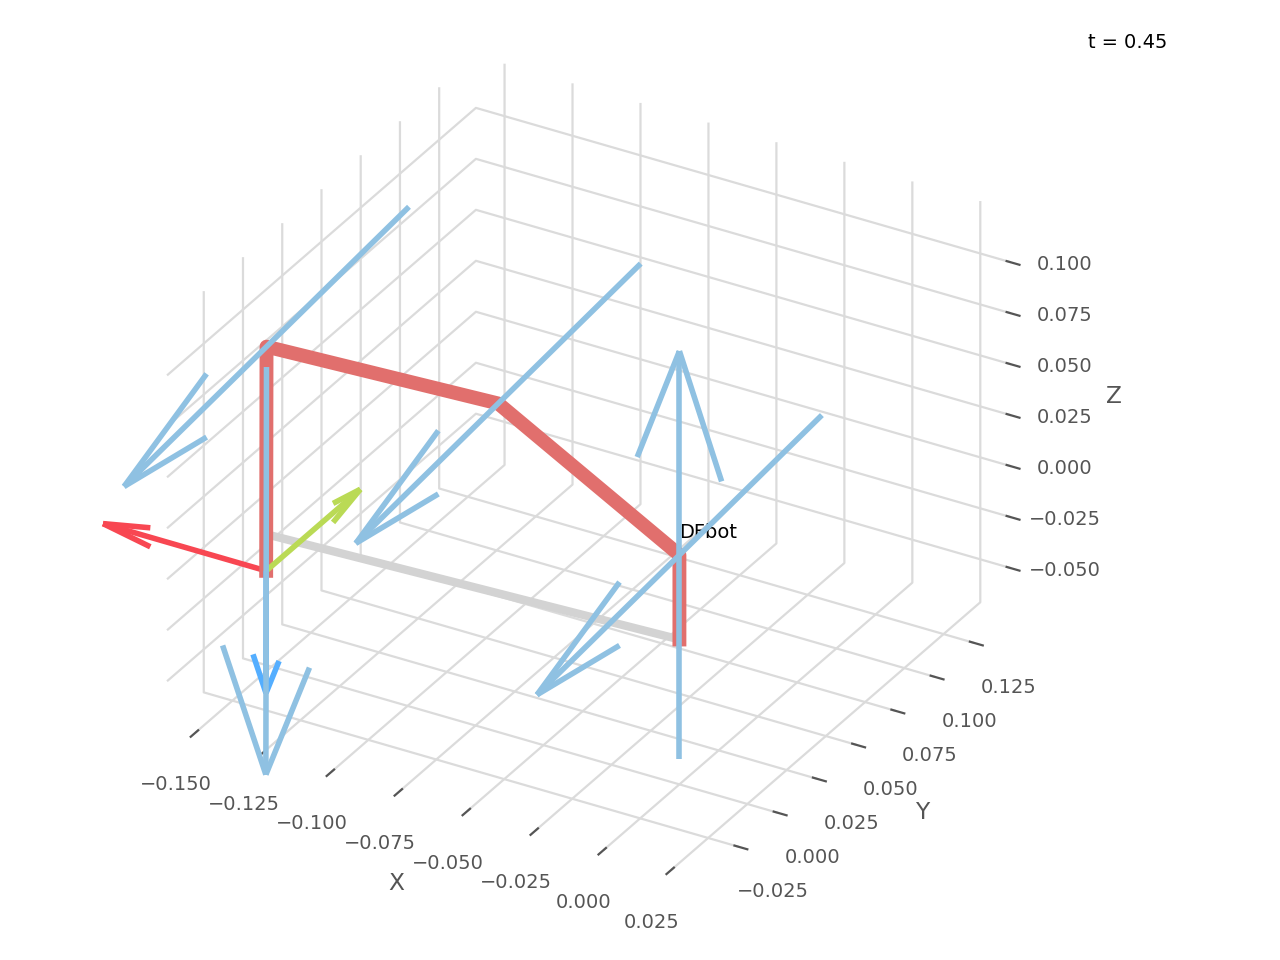

PyPlot3D backend, t = 0.49999999999999994, scene:
  robot: Text(0.0, 0.0, 'DFbot')

In [940]:
qt = jtraj([0,-np.pi/3,np.pi/3,np.pi,0], sol.q, 10)
DFbot2.plot(qt.q, backend='pyplot', movie='panda1.gif')